# First imports

## Initial global imports

In [4]:
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234
tf.random.set_seed(SEED)

cwd = os.getcwd()
from tensorflow.keras.models import 

## Necessary to work with JSON and preprocessing

In [5]:
import json
import shutil
import random

# Preprocessing the images

## Initial directories to work with

In [6]:
# Defining the datasets directory
dataset_dir = os.path.join(cwd, 'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# Create validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

## Defining images classes

In [7]:
# Loading the classes of each image into the memory
train_classes_json_file_name = 'train_gt.json'
train_classes_json_directory = os.path.join(dataset_dir, train_classes_json_file_name)

data = {}

with open(train_classes_json_directory) as json_file:
    data = json.load(json_file)

## Preparing folders for Keras usage in a later moment

In [8]:
# Creating folder for each class of image for training and validation datasets
classes = set(data.values())
print(classes)

for class_label in classes:
    class_training_dir = os.path.join(training_dir, str(class_label))
    class_validation_dir = os.path.join(validation_dir, str(class_label))
    if not os.path.exists(class_training_dir):
        os.makedirs(class_training_dir)
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

{0, 1, 2}


In [9]:
# Assigning images to each training folder/class, avoiding to have the same image two times in the same folder
for entry in os.scandir(training_dir):
    if(entry.is_file()):
        file_destination = os.path.join(training_dir, str(data[entry.name]), entry.name)
        if not os.path.isfile(file_destination):
            shutil.copy(entry.path, file_destination)
    
# Choosing random images to be into the validation folders, being able to repeat without cloning images
validation_rate = 0.1

for class_label in classes:
    class_training_dir = os.path.join(training_dir, str(class_label))
    class_validation_dir = os.path.join(validation_dir, str(class_label))
    
    for old_entry in os.scandir(class_validation_dir):
        os.remove(old_entry.path)
    
    training_entries = list(os.scandir(class_training_dir))
    validation_size = round(len(training_entries)*validation_rate)
    
    for validation_entry in random.sample(training_entries, validation_size):
        destination = os.path.join(class_validation_dir, validation_entry.name)
        os.rename(validation_entry.path, destination)

# Data augmentation

## Data generation

In [10]:
apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=10,
        height_shift_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0,
        rescale=1/255.
    )
else:
    train_data_gen = ImageDataGenerator(rescale=1/255.)

valid_data_gen = ImageDataGenerator(rescale=1/255.)
# test_data_gen = ImageDataGenerator(rescale=1/255.)

## Data loader from directory

In [11]:
bs = 8

train_gen = train_data_gen.flow_from_directory(
    training_dir,
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_gen = valid_data_gen.flow_from_directory(
    validation_dir,
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# test_gen = test_data_gen.flow_from_directory(
#     test_dir,
#     batch_size=bs,
#     class_mode='categorical',
#     shuffle=True,
#     seed=SEED
# )

Found 5052 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [25]:
img_h = 256
img_w = 256

num_classes = len(classes)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None, num_classes])
)

#train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None, num_classes])
)

# valid_dataset = valid_dataset.repeat()

# test_dataset = tf.data.Dataset.from_generator(
#     lambda: test_gen,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 256, 256, 3], [None, num_classes])
# )

# test_dataset = test_dataset.repeat()

## Testing the dataset

In [26]:
iterator = iter(train_dataset)

[]

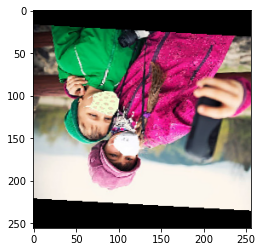

In [28]:
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0]) # it was a tensor, so we need to transform it into an array
augmented_img = augmented_img * 255 # normalizing

plt.imshow(np.uint8(augmented_img))
plt.plot()

# CNN part ;)

## Building the network

In [30]:
start_f = 8
depth = 5

model = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape = [None]

    # Convolutional part
    model.add(
        tf.keras.layers.Conv2D(
            filters=start_f,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            input_shape=input_shape
    ))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    start_f *= 2

# Fully connected part
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4

## Compiling the model

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
%load_ext tensorboard
%tensorboard --logdir 'D:\Polimi\Lectures\3semester\artificial-neural-networks-and-deep-learning\Homeworks\1st\classification_experiments\'

Launching TensorBoard...

In [18]:
exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, 'cp_.ckpt'), #'cp_{epoch:02d}.ckpt'
    save_weights_only=True # False to save the model directly
)
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tb_dir,
    profile_batch=0,
    histogram_freq=1 # if 1 shows weights histograms
)
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [33]:
model.fit(
    x=train_dataset,
    epochs=100,
    steps_per_epoch=len(train_gen),
    validation_data=valid_dataset,
    validation_steps=len(valid_gen),
    callbacks=callbacks
)

Train for 632 steps, validate for 71 steps
Epoch 1/100
632/632 [==============================] - 97s 154ms/step - loss: 1.0891 - accuracy: 0.3834 - val_loss: 1.0392 - val_accuracy: 0.4822
Epoch 2/100
632/632 [==============================] - 83s 132ms/step - loss: 1.0222 - accuracy: 0.4662 - val_loss: 0.9605 - val_accuracy: 0.5587
Epoch 3/100
632/632 [==============================] - 82s 129ms/step - loss: 0.9663 - accuracy: 0.5085 - val_loss: 0.8953 - val_accuracy: 0.5569
Epoch 4/100
632/632 [==============================] - 87s 138ms/step - loss: 0.9187 - accuracy: 0.5388 - val_loss: 0.8819 - val_accuracy: 0.5676
Epoch 5/100
632/632 [==============================] - 84s 133ms/step - loss: 0.8881 - accuracy: 0.5673 - val_loss: 0.8449 - val_accuracy: 0.5712
Epoch 6/100
632/632 [==============================] - 82s 130ms/step - loss: 0.8648 - accuracy: 0.5821 - val_loss: 0.8529 - val_accuracy: 0.5285
Epoch 7/100
632/632 [==============================] - 81s 129ms/step - loss: 0.8